In [163]:
from functools import lru_cache, partial
from collections import defaultdict, deque
from pathlib import Path
from glob import glob
import re
import random
import math
import numpy as np
from scipy import stats, special
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sortedcontainers import SortedList, SortedDict, SortedSet
from pyfaidx import Fasta
from Bio import SeqIO
import mmh3
from pafpy import PafFile

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 400
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

# Formulas for calculating minmer density

In [100]:
@lru_cache(maxsize=None)
def prerr(w, r1, rw, ss):
    acc = 0
    dist = stats.hypergeom(w-1, r1-1, w-rw)
    if r1 <= ss or rw <= ss:
        return 1
    for u in range(1, min(r1 -1, w-rw)+1):
        if 2*u + rw - r1 >= u and u + rw - ss >= 0:
            path_prob = math.comb(2*u + rw - r1, u+rw -ss) / math.comb(2*u + rw -r1, u)
            hgeom_prob = dist.pmf(u)
            if path_prob > 1:
                print(f"u={u}, r1={r1}, rw={rw}, p={path_prob:.3f}")
            acc += hgeom_prob*path_prob
    return acc

@lru_cache(maxsize=None)
def minmer_density_w(w, ss, use_tqdm=True):
    adata = np.arange(0, w-1, dtype=int)
    ranks = np.arange(1, w+1, dtype=int)
    acc = []
    for r in (tqdm(ranks) if use_tqdm else ranks):
        alpha = r
        beta = w - r + 1
        betaBinDist = stats.betabinom(w-1, alpha, beta)
        if r <= ss:
            acc.append(1/len(ranks))
        else:
            eps = .0001
            amin = int(betaBinDist.ppf(eps))
            amax = int(betaBinDist.ppf(1-eps)) + 1
            acc.append(sum([
                (betaBinDist.pmf(a)*(prerr(w, r, a+1, ss) if a >= ss else 1)) for a in range(amin, min(amax, w-(r - ss)))
            ]) /  len(ranks))
            if (w-r)*acc[-1] <= eps:
                break
    return sum(acc)

# Figure 3

In [118]:
w = 1000
exact = []
minimizerFixedSS = []
minimizer_sses = list(range(1, w+1, 1))
minmer_sses = list(range(1, w+1, 1))

for ss in tqdm(minimizer_sses):
    minimizer_w = math.floor(w/ss)
    minimizerFixedSS.append(2/((minimizer_w)+1))
    
for ss in tqdm(minmer_sses):
    exact.append(minmer_density_w(w, ss, use_tqdm=False))
    
plt.title(f"Density of methods with a $({w},s)$-guarantee")
plt.xlabel("$s$")
plt.ylabel("Density")
plt.plot(minmer_sses, np.array(exact), label='Minmer density', color="steelblue")
plt.plot(minimizer_sses, np.array(minimizerFixedSS), label='Minimizer density', color="goldenrod")
plt.plot(minimizer_sses, [ss/w for ss in minimizer_sses], linestyle="dashed",  label='Optimal lower bound = $\\frac{s}{w}$', color="black")
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Figure 4

In [29]:
human_ref = "/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna"
target_fai = Fasta(human_ref)
target_index = SeqIO.index(human_ref, "fasta")

In [35]:
kmer_size = 18
SEED=42
genome_seq = str(target_index["chrY"].seq).upper()
genome_hashes = [mmh3.hash64(genome_seq[i:i+kmer_size], seed=SEED, signed=False) for i in tqdm(range(len(genome_seq) - kmer_size + 1))]
N = len(genome_hashes)
simulated_hashes = random.choices(range(0, 2**60), k=N)

  0%|          | 0/62460012 [00:00<?, ?it/s]

In [56]:
s_list = [10, 50, 100, 200]
w = 1000

ss_to_sketched = {
    "simulated": {s: np.zeros(len(genome_hashes), dtype=bool) for s in s_list},
    "empirical": {s: np.zeros(len(simulated_hashes), dtype=bool) for s in s_list}
}


for hash_seq, name in [(simulated_hashes, "simulated"), (genome_hashes, "empirical")]:
    N = len(hash_seq)
    active_counter = defaultdict(deque)
    sorted_window = SortedSet((h) for (idx, h) in enumerate(hash_seq[:w]))
    for i, h in enumerate(hash_seq[:w]):
        active_counter[h].append(i)
        # index_to_rank[i] = sorted_window.bisect_left(((genome_hashes[i]) + 1))
    for i in tqdm(range(1, N-w+1)):
        active_counter[hash_seq[i-1]].popleft()
        active_counter[hash_seq[i + w - 1]].append(i+w-1)
        if len(active_counter[hash_seq[i-1]]) == 0:
            sorted_window.discard(hash_seq[i-1])
            del active_counter[hash_seq[i-1]]
        sorted_window.add(hash_seq[i + w - 1])

        assert(len(active_counter) == len(sorted_window))
        for s in s_list:
            cutoff = sorted_window[min(s-1, len(sorted_window)-1)]

            # Check if new hash in in sketch
            if hash_seq[i + w - 1] <= cutoff:
                sidx = active_counter[hash_seq[i + w - 1]][0]
                ss_to_sketched[name][s][sidx] = True 

            # Check if old hash in in sketch
            if hash_seq[i - 1] <= cutoff and hash_seq[i - 1] in active_counter:
                sidx = active_counter[hash_seq[i - 1]][0]
                ss_to_sketched[name][s][sidx] = True 

            sketch_border_elem = active_counter[sorted_window[min(s-1, len(sorted_window)-1)]][0]
            ss_to_sketched[name][s][sketch_border_elem] = True
        

  0%|          | 0/62459012 [00:00<?, ?it/s]

  0%|          | 0/62459012 [00:00<?, ?it/s]

In [48]:
def minimizer(nums, w):
    """
    :type nums: List[int]
    :type k: int
    :rtype: List[int]
    """
    d = deque()
    out = []
    for i, n in tqdm(list(enumerate(nums))):
        while d and nums[d[-1]] > n:
            d.pop()
        d.append(i)
        if d[0] == i - w:
            d.popleft()
        if i>=w-1:
            out.append(d[0])
    return out

def minimizerWindowLen(density):
    return 2/density -1

34.0
Theoretical minmer density =  0.057, actual density =  0.060


  0%|          | 0/62460012 [00:00<?, ?it/s]

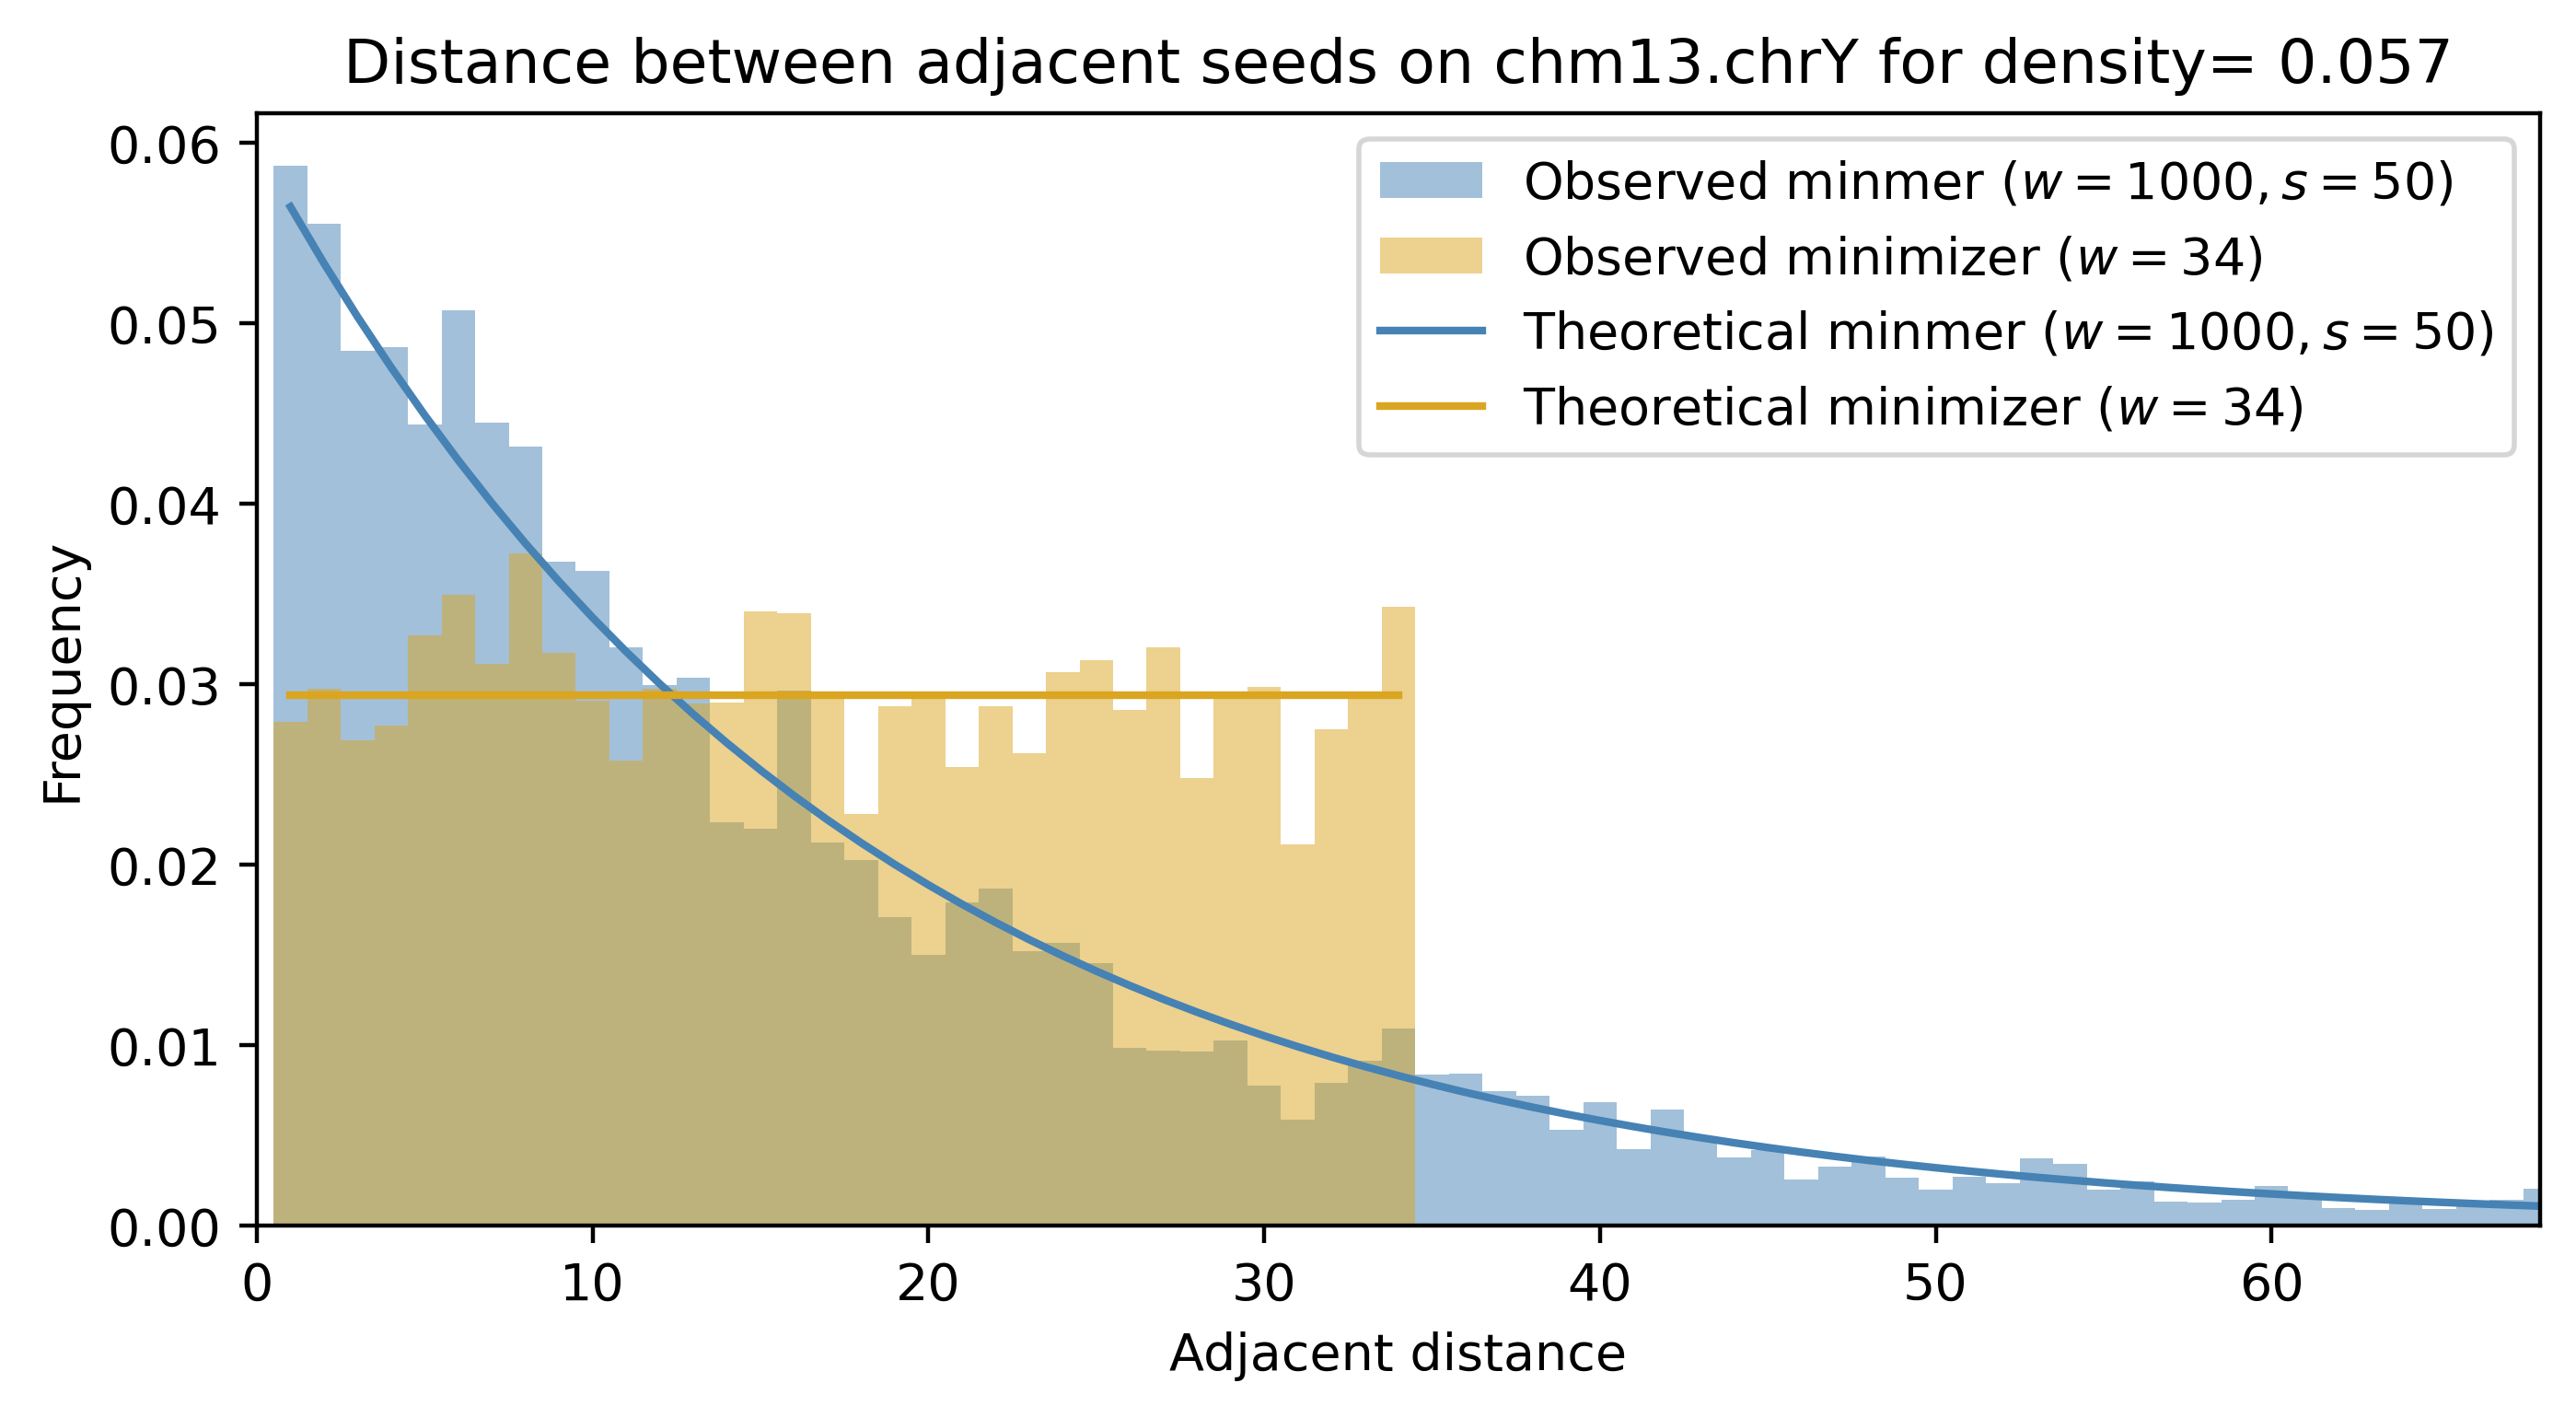

34.0
Theoretical minmer density =  0.057, actual density =  0.058


  0%|          | 0/62460012 [00:00<?, ?it/s]

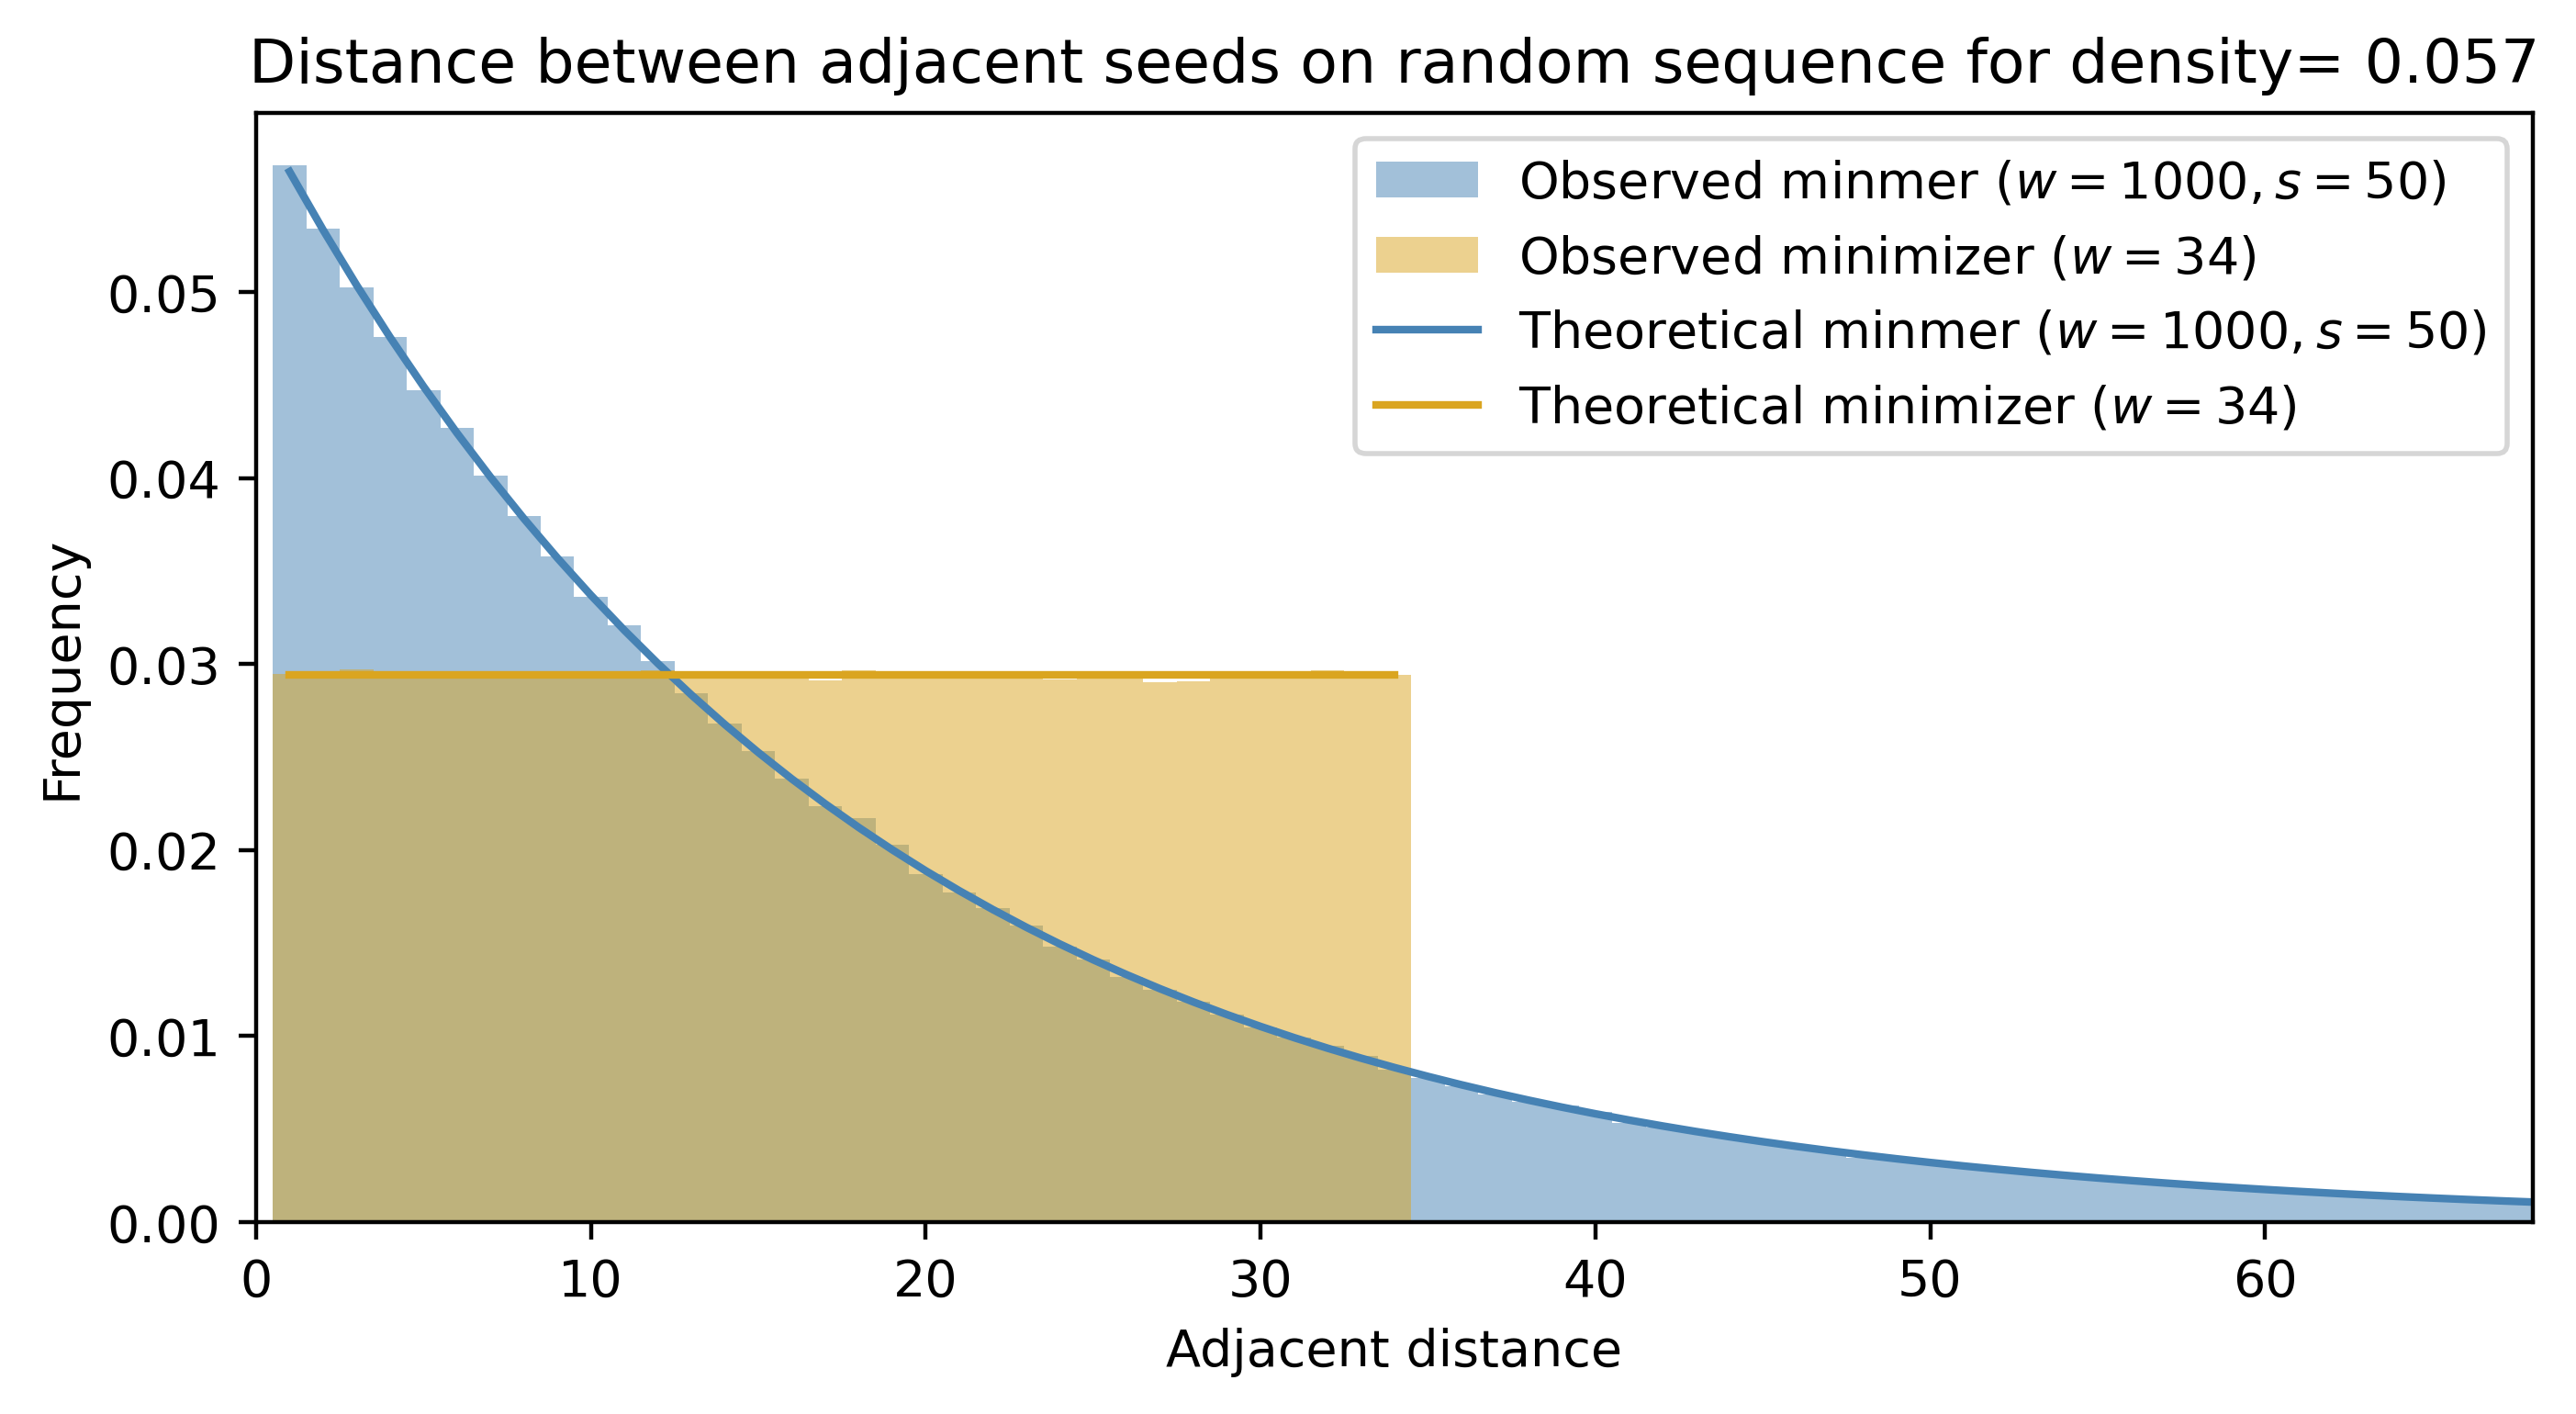

In [62]:
ss = 50

for dataset, seqName in [("empirical", "chm13.chrY"), ("simulated", "random sequence")]:
    ssts = ss_to_sketched[dataset][ss]
    hash_seq = simulated_hashes if dataset == "simulated" else genome_hashes

    minmer_density = minmer_density_w(w, ss)

    corresponding_minimizer_w = np.round(minimizerWindowLen(minmer_density))
    print(corresponding_minimizer_w)
    minmer_sketched_idx_list = sorted(ssts.nonzero()[0])
    print(f"Theoretical minmer density = {minmer_density : .3f}, actual density = {len(minmer_sketched_idx_list)/len(hash_seq) : .3f}")
    minmer_dist_list = [minmer_sketched_idx_list[i] - minmer_sketched_idx_list[i-1] for i in range(1, len(minmer_sketched_idx_list))]
    max_w = int(max(minmer_dist_list)) + 1

    minimizer_sketched_idx_list = sorted(set(minimizer(hash_seq, corresponding_minimizer_w)))
    minimizer_dist_list = [minimizer_sketched_idx_list[i] - minimizer_sketched_idx_list[i-1] for i in range(1, len(minimizer_sketched_idx_list))]

    minmer_df = minmer_density * (w+1)

    sample_size = int(min(1e6, len(minmer_dist_list), len(minimizer_dist_list)))
    binsize=1
    # plt.xlim(-1, k+5)

    plt.title(f"Distance between adjacent seeds on {seqName} for density={minmer_density : 0.3f}")
    minmer_hist = plt.hist(random.sample(minmer_dist_list, sample_size), bins=range(0, max_w+1, binsize), alpha=.5, density=True, color="steelblue", label=f"Observed minmer $(w={w}, s={ss})$", align="left")
    minimizer_hist = plt.hist(random.sample(minimizer_dist_list, sample_size), alpha=.5, bins=range(0, max_w+1, binsize), density=True, color="goldenrod",  label=f"Observed minimizer $(w={int(corresponding_minimizer_w)})$", align="left")

    Ds = range(1,int(3*corresponding_minimizer_w))
    minimizer_Ds = range(1,int(corresponding_minimizer_w)+1)
    plt.plot(Ds, [special.comb(w-d, max(0, minmer_df-2)) / special.comb(w, minmer_df-1) for d in Ds], color="steelblue", label=f"Theoretical minmer $(w={w}, s={ss})$")
    plt.plot(minimizer_Ds, [1/corresponding_minimizer_w if d < corresponding_minimizer_w+1 else 0 for d in minimizer_Ds], color="goldenrod", label=f"Theoretical minimizer $(w={int(corresponding_minimizer_w)})$")
    plt.legend()
    plt.xlim(0, 2*corresponding_minimizer_w)
    plt.ylim(0, max(max(minmer_hist[0]), max(minimizer_hist[0]))*1.05)
    plt.xlabel("Adjacent distance")
    plt.ylabel("Frequency")
    plt.show()


# Figure 5
* Datasets available from Belbasi et al. [here](https://github.com/medvedevgroup/minimizer-jaccard-estimator)
* MashMap2 (modified to use the binomial model) and MashMap3 were run with a segment length of 10,000 and a kmer size of 19. All other parameters were set to the default.
* Averages can be obtained from a paf file via

```bash
alias computeAvg="awk '{ sum += \$1; n++ } END { if (n > 0) print sum / n; }'"
cut $PAF -f13 | computeAvg
```

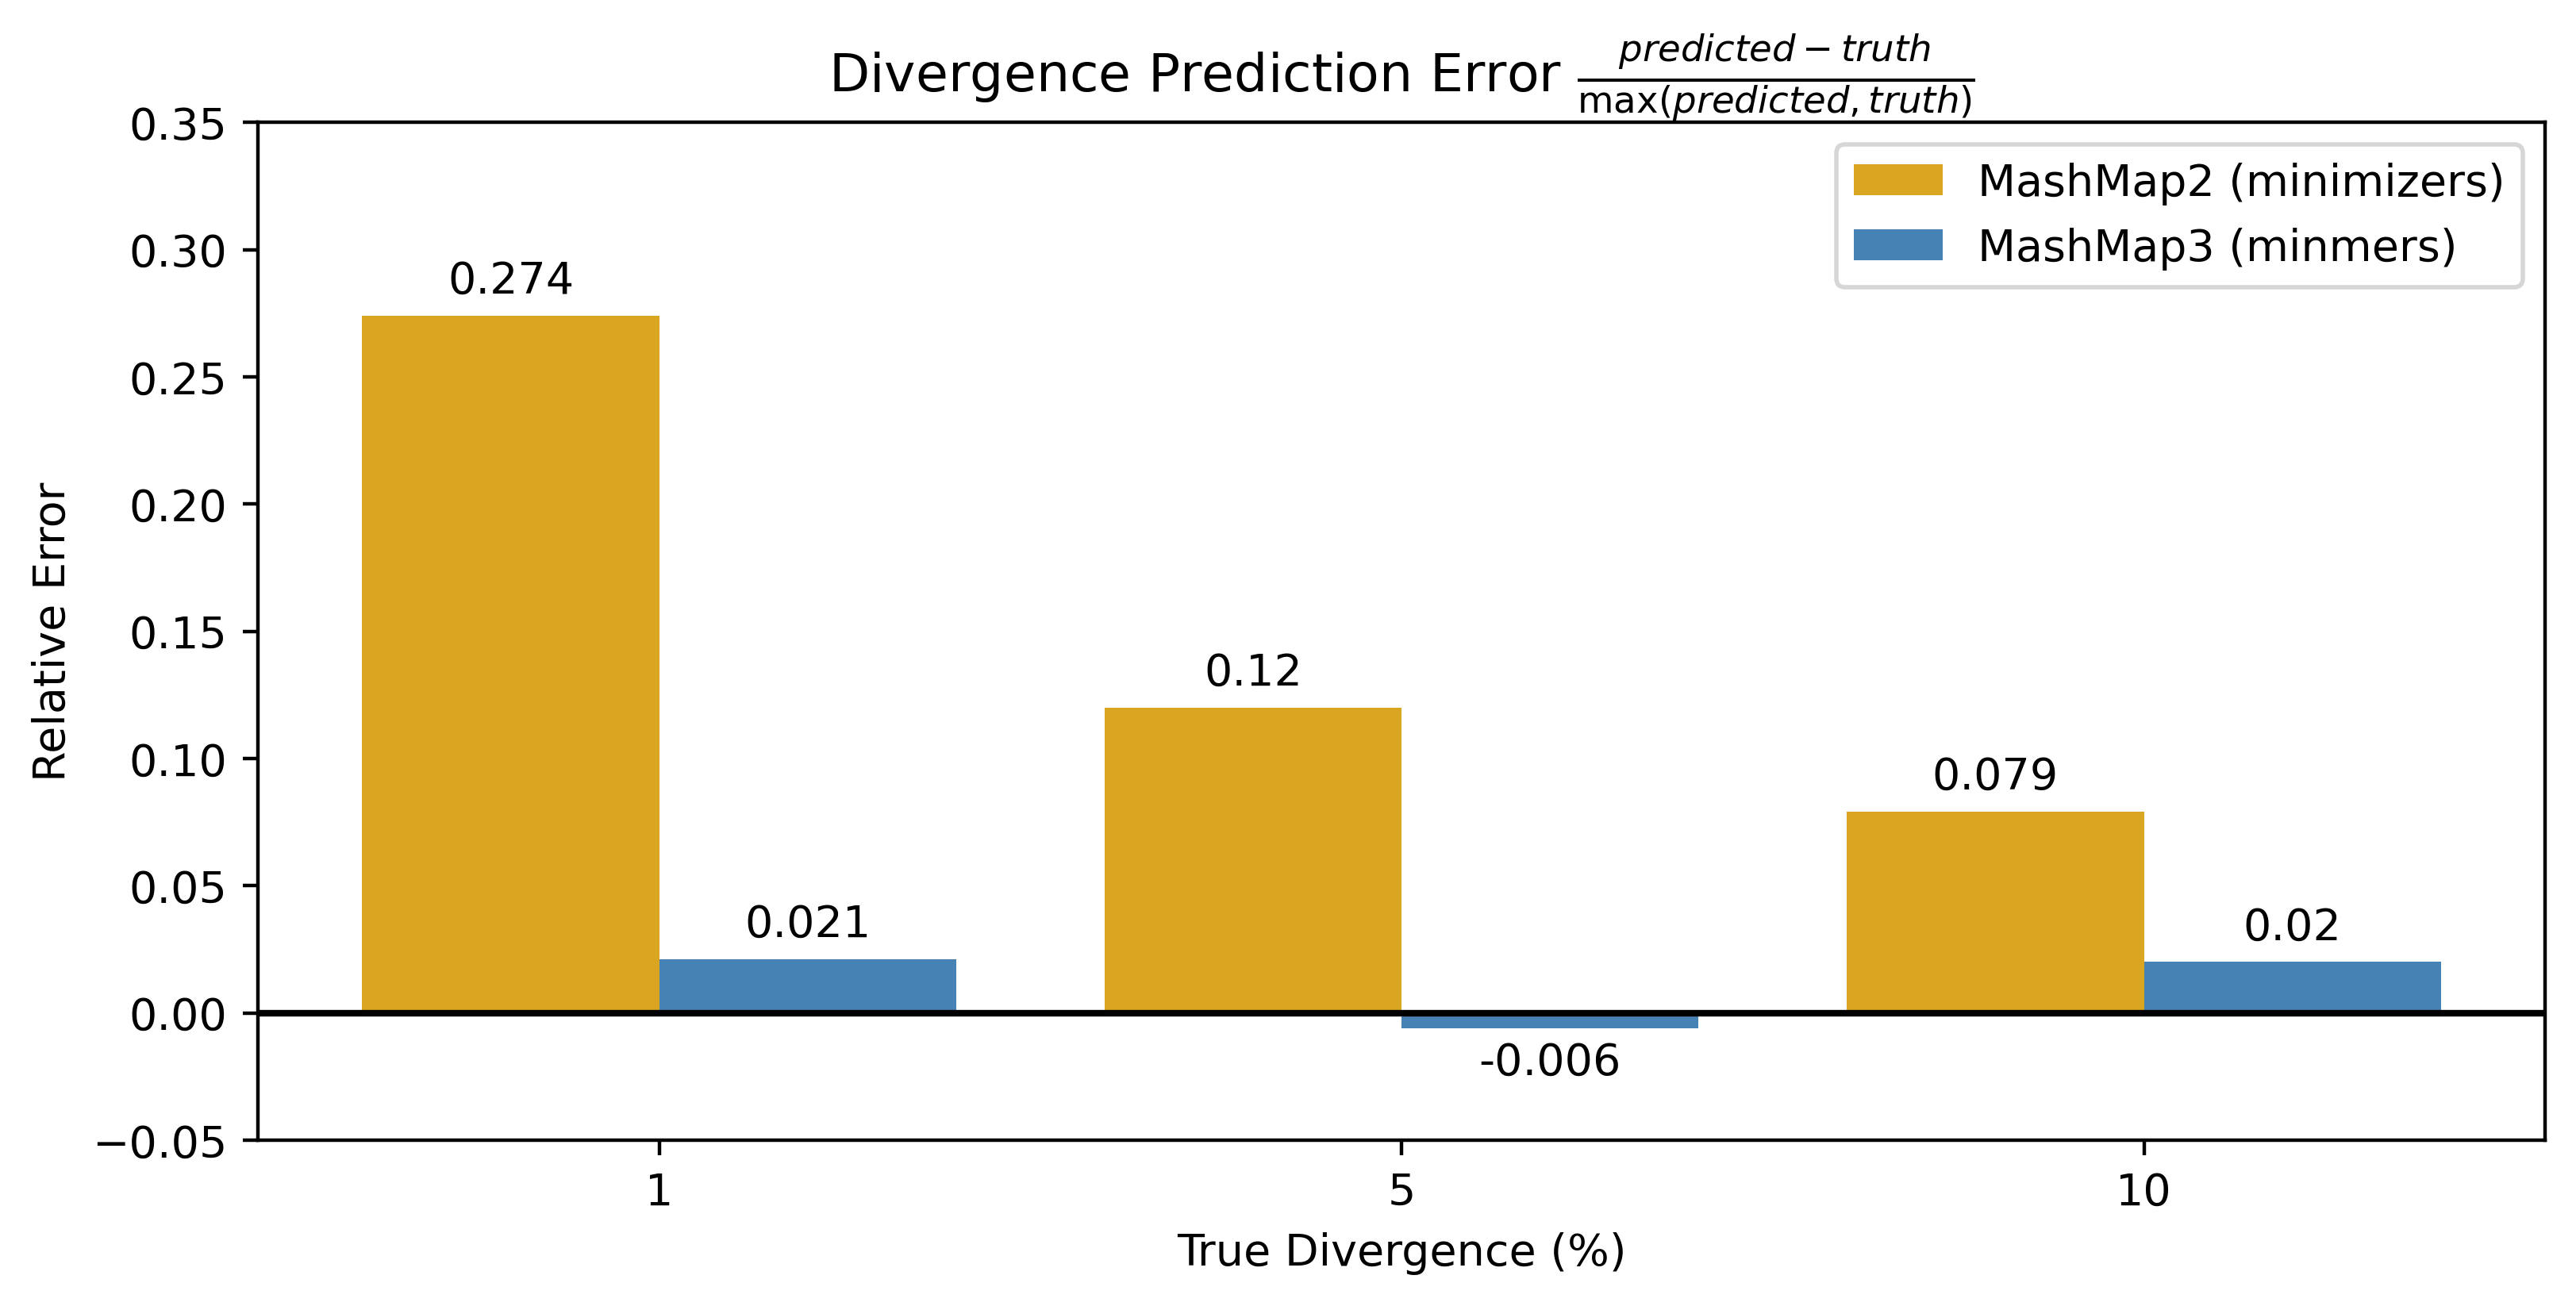

In [64]:
bb_results = {
    "1": {"MashMap2": 0.274, "MashMap3": 0.021},
    "5": {"MashMap2": 0.120, "MashMap3": -0.006},
    "10": {"MashMap2": 0.079, "MashMap3": 0.020}}

tools = ["MashMap2", "MashMap3"]
tool_to_label = {"MashMap2": "MashMap2 (minimizers)", "MashMap3": "MashMap3 (minmers)"}
tool_to_color = {"MashMap2": "goldenrod", "MashMap3": "steelblue"}
divs = [1, 5, 10]
x = np.arange(3)  # the label locations
width = 0.4 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for tool in tools:
    offset = width * multiplier
    rects = ax.bar(x + offset, [d[tool] for d in bb_results.values()], width, label=tool_to_label[tool], color=tool_to_color[tool])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Error')
ax.set_xlabel("True Divergence (%)")
ax.set_title(r'Divergence Prediction Error $\frac{predicted - truth}{\max(predicted, truth)}$')
ax.set_xticks(x + width/2, divs)
ax.legend()
ax.axhline(0, color="black")
ax.set_ylim((-.05, 0.35))

plt.show()

# Tables 1 and 2

The following cell contains the function used to parse the output of `/usr/bin/time -v`

In [ ]:
import re

PerformanceProfile = namedtuple("PerformanceProfile", ["cputime", "walltime", "memory"])
BasicAlignment =  namedtuple("BasicAlignment", ["length", "ANI_est", "ANI_wfmash"])


def file_to_profile(input_f):
    kbInGb = 1048576
    user, sys, walltime, cputime, memory = 0, 0, 0, 0, 0
    if not Path(input_f).exists():
        # print(input_f)
        return None
    with open(input_f) as profile_in:
        for line in profile_in:
            m = re.search(r'User time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                user = float(m.groupdict()["time"])
                continue
            m = re.search(r'System time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                sys = float(m.groupdict()["time"])
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+:\d+)', line)
            if m:
                h, mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm), hours=float(h))
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+.\d+)', line)
            if m:
                mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm))
                continue
            m = re.search(r'Maximum resident set size \(kbytes\): (?P<mem>\d+)', line)
            if m:
                memory = int(m.groupdict()["mem"])
                continue
            
            m = re.search(r'Exit status: (?P<status>\d+)', line)
            if m:
                if m.groupdict()["status"] != "0":
                    return None
                continue
        cputime = timedelta(seconds=user+sys)
    return PerformanceProfile(np.round(cputime.total_seconds() / 60, 2), np.round(walltime.total_seconds() / 60, 2), np.round(memory / kbInGb, 2)) if (cputime and walltime and memory) else None

def print_profile(tool_to_profile):
    print(f"{'Method': ^40}\t{'CPU time (m)' : ^8}\t{'Wall time (m)' : ^8}\t{'Memory (GiB)' : ^8}")
    for tool, prof in tool_to_profile.items():
        if not prof:
            print(f"{tool.name: <20}t{tool.pi : <4}\t{tool.ss : <4}\t{'...' : <8}\t{'...' : <8}\t{'...' : <8}")
        else:
            print(f"{tool.name: <20}\t{tool.pi : <4}\t{tool.ss : <4}\t{prof.cputime : <8}\t{prof.walltime : <8}\t{prof.memory : <8}")

## Table 1

The following script was used to generate the reads for Table 1

```bash
#/usr/bin/env bash
for ANI in 95 98 99; do
    NAME="ONT-${ANI}"
    pbsim \
        --prefix pbsim/${name} \
        --length-mean 5000 --length-min 5000 --length-max 5000 \
        --accuracy-mean .${ANI} --accuracy-sd 0 \
        --model_qc ${CLR_PROFILE} \
        --depth 2 \
        --difference-ratio 20:40:40 \
        ${T2T_FASTA}
    paftools.js pbsim2fq ${T2T_FAI} pbsim/${NAME}_*.maf > ${NAME}.fa
    shuffle.sh in=${name}.fa out=${NAME}.shuffled.fa
    mv ${NAME}.shuffled.fa ${NAME}.fa
done

```

In [164]:
# Code used to compute the ground truth gap-compressed ANI of the simulated sequences.

ANI_to_gcANI = defaultdict(dict)
ANI_to_k_to_J = defaultdict(lambda: defaultdict(dict))
ANI_to_length =  defaultdict(dict)
k = 19

gap_regex = re.compile(r'(-)+')

for ANI in [95, 98, 99]:
    maf_files = glob(f"/home/Users/blk6/Data/reads/human/pbsim/ONT-{ANI}-nosd-balanced-d2-5000_00*.maf")
    print(ANI)
    for maf_file in (maf_files):
        counter = 0
        num_lines = sum(1 for line in open(maf_file))
        for line_no, line in (enumerate(line.strip() for line in open(maf_file))):
            if line == "":
                continue
            if line[0] == "a":
                if counter == 2:
                    match_columns = sum(ref_aln[i] == query_aln[i] for i in range(len(query_aln)))
                    s = query_aln + "SEP" + ref_aln
                    gap_columns_compressed_extra = s.count("-") - len(gap_regex.findall(s))
                    total_columns = len(ref_aln)
                    
                    ## Code for computing the jaccard. Very expensive, so only compute on subset
                    # ref_aln = ref_aln.replace("-", "")
                    # query_aln = query_aln.replace("-", "")
                    # ref_set = set(ref_aln[i:i+k] for i in range(len(ref_aln)-k+1))
                    # query_set = set(query_aln[i:i+k] for i in range(len(query_aln)-k+1))
                    # if len(ref_set) == len(ref_aln) - k + 1:
                    #     if len(query_set) == len(query_aln) - k + 1:
                    # ANI_to_k_to_J[ANI][k][rid] = len(ref_set & query_set) / len(ref_set | query_set) 
                    
                    ANI_to_gcANI[ANI][rid] = 100*match_columns / (total_columns - gap_columns_compressed_extra)
                    ANI_to_length[ANI][rid] = (len(ref_aln), len(query_aln))
                    
                counter = 0
            elif line[0] == "s" and counter == 0:
                counter += 1
                ref_aln = line.split(" ")[-1].upper()
            elif line[0] == "s" and counter == 1:
                rid = line.split(" ")[1]
                query_aln = line.split(" ")[-1].upper()
                counter += 1
    print(stats.describe(list(ANI_to_gcANI[ANI].values())))
    plt.hist(list(ANI_to_gcANI[ANI].values()), bins=20)
    plt.show()
    # plt.hist(list(ANI_to_k_to_J[ANI][19].values()), bins=20)
    # plt.show()


95


KeyboardInterrupt: 

In [ ]:
ANI = 95
paf_filepath=f"/home/Users/blk6/Contribute/wfmash/benchmarking/chm13-ONT-indel-balanced-{ANI}-reads/mashmap2-ss100-k19-p{ANI-5}-n1-L5000/mashmap2.approx.paf"
with open(paf_filepath) as paf_in:
    results = [(r.tags["id"].value, ANI_to_gcANI[95][r.qname.split("!")[0]]) for r in PafFile(paf_in) if get_min_complexity(ref, query, r) > MIN_COMPLEXITY]
    print(f"ME: {np.mean([x[0] - x[1] for x in results]) : 0.3f}\tMAE: {np.mean([abs(x[0] - x[1]) for x in results]) : 0.3f}")
        

## Table 2

The following will obtain the mean error and mean absolute error on a paf file aligned with `wfmash`. Note that this does not discard low complexity regions as in the paper. 

```bash
alias computeME="awk '{ sum += \$1; n++ } END { if (n > 0) print sum / n; }'"
alias computeMAE="awk '{ sum += (\$1 > 0 ? \$1 : -\$1); n++ } END { if (n > 0) print sum / n; }'"
cat  ${ALIGNED_PAF} | awk '{split($13, gi, ":"); split($15, md, ":"); print (md[3]-gi[3]);}' | computeME
cat  ${ALIGNED_PAF} | awk '{split($13, gi, ":"); split($15, md, ":"); print (md[3]-gi[3]);}' | computeMAE
```

In [433]:
def index_fasta(fasta_file):
    return {record.id: record.seq.upper() for record in (SeqIO.parse(fasta_file, "fasta"))}

human_index = index_fasta("/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna")
chimp_index = index_fasta("/home/Users/blk6/Data/assemblies/chimpanzee/Clint_PTRv2.fna")
macaque_index =  index_fasta("/home/Users/blk6/Data/assemblies/macaque/GCF_003339765.1_Mmul_10_genomic.fna")

name_to_index = {
    "human": human_index,
    "chimpanzee": chimp_index,
    "macaque": macaque_index
}


In [435]:
# Get the complexity of a sequence
def get_seq_complexity(seq, k=19):
    kmers = set(str(seq[i:i+k]) for i in range(len(seq) - k + 1))
    return len(kmers) / (len(seq) - k + 1)

# Return the minimum complexity between two sequences
# where r is a record for the PafPy 
def get_min_complexity(ref, query, r, k=19):
    tseq = name_to_index[ref][r.tname][r.tstart:r.tend]
    qseq = name_to_index[query][r.qname][r.qstart:r.qend]
    return min(
        get_seq_complexity(tseq, k) if len(tseq) >= k else 1,
        get_seq_complexity(qseq, k) if len(qseq) >= k else 1)

In [205]:
ref = "human"
params_to_results = {}

for query in ["chimpanzee", "macaque"]:
    params_to_results[query] = {}
    for (ss, pi) in [(200, 95), (300, 85), (400, 75)]:
        params_to_results[query][(ss, pi)] = {}
        for tool in ["mashmap2", "mashmap3"]:
            params_to_results[query][(ss, pi)][tool] = {}
            paf_filepath=f"/home/Users/blk6/Contribute/wfmash/output-pafs-nomerge/{ref}-{query}/{ref}-{query}.L5000.ss{ss}.p{pi}.{tool}.aligned.paf"
            if Path(paf_filepath).exists():
                params_to_results[query][(ss, pi)][tool] = list(PafFile(open(paf_filepath)))


In [348]:
SAMPLE_N = 50000
MIN_COMPLEXITY = 0.8

for query in params_to_results:
    print(f"{ref}--{query}")
    print("-"*20)
    for (ss, pi) in params_to_results[query]:
        for tool in params_to_results[query][(ss, pi)]:
            if len(params_to_results[query][(ss, pi)][tool]) < 1:
                print(f"No records for {tool:<10}  pi={pi : <4}  ss={ss : <4}  ")
                print()
                continue
            sampled_records = random.sample(params_to_results[query][(ss, pi)][tool], SAMPLE_N)
            errs = []
            low_complexity_errs = []
            lens = []
            for idx, r in tqdm(enumerate(sampled_records)):
                # complexity = get_min_complexity(ref, query, r) 
                min_len = min(
                    r.tend - r.tstart,
                    r.qend - r.qstart)
                if min_len < 19: 
                    print(r)
                    continue
                # if complexity >= MIN_COMPLEXITY:
                    errs.append((r.tags["md"].value - r.tags["gi"].value))
                else:
                    low_complexity_errs.append((r.tags["md"].value - r.tags["gi"].value))
                lens.append(min(r.query_aligned_length, r.target_aligned_length))
            plt.show()
            print(f"{tool:<10}  pi={pi : <4}  ss={ss : <4}  ")
            print(f"Low complexity ME: {np.mean(low_complexity_errs) : 0.3f}\tLow complexity MAE: {np.mean([abs(x) for x in low_complexity_errs]) : 0.3f}")
            print(f"Filtered ME: {np.mean(errs) : 0.3f}\tFiltered MAE: {np.mean([abs(x) for x in errs]) : 0.3f}")
            print(f"Overall ME: {np.mean(low_complexity_errs + errs) : 0.3f}\tOverall MAE: {np.mean([abs(x) for x in (low_complexity_errs + errs)]) : 0.3f}")
            print(f"{len(errs)}/{len(sampled_records)} ={100*len(errs)/len(sampled_records) : .2f}% of records pass the complexity filter")
            print()


human--chimpanzee
--------------------


0it [00:00, ?it/s]

mashmap2    pi=95    ss=200   
Low complexity ME:  0.372	Low complexity MAE:  1.092
Filtered ME: -0.251	Filtered MAE:  0.287
Overall ME: -0.248	Overall MAE:  0.291
49772/50000 = 99.54% of records pass the complexity filter



0it [00:00, ?it/s]

mashmap3    pi=95    ss=200   
Low complexity ME:  0.782	Low complexity MAE:  1.339
Filtered ME:  0.004	Filtered MAE:  0.228
Overall ME:  0.009	Overall MAE:  0.234
49723/50000 = 99.45% of records pass the complexity filter



0it [00:00, ?it/s]

mashmap2    pi=85    ss=300   
Low complexity ME:  4.499	Low complexity MAE:  4.812
Filtered ME: -0.184	Filtered MAE:  0.264
Overall ME: -0.112	Overall MAE:  0.334
49228/50000 = 98.46% of records pass the complexity filter



0it [00:00, ?it/s]

NC_036901.1	33698415	7610000	7610255	+	chr9	150617247	92820844	92820847	3	255	0	gi:f:75.0	bi:f:1.17647	md:f:81.5968	wt:i:251	pt:i:2	aa:i:1501	ap:i:175	cg:Z:252I3=
mashmap3    pi=85    ss=300   
Low complexity ME:  4.906	Low complexity MAE:  5.078
Filtered ME:  0.017	Filtered MAE:  0.265
Overall ME:  0.117	Overall MAE:  0.364
48969/50000 = 97.94% of records pass the complexity filter

No records for mashmap2    pi=75    ss=400   



0it [00:00, ?it/s]

NC_036892.1	95599650	49475137	49475392	-	chr2	242696752	69516376	69516376	0	255	255	gi:f:0.0	bi:f:0.0	md:f:78.5071	wt:i:455	pt:i:2	aa:i:1547	ap:i:376	cg:Z:255I
NW_019933478.1	84936	64608	64864	+	chr2	242696752	51491031	51491033	2	256	0	gi:f:66.6667	bi:f:0.78125	md:f:78.4554	wt:i:515	pt:i:4	aa:i:1553	ap:i:153	cg:Z:254I2=
NW_019933550.1	78887	70000	70256	+	chr19	61707364	36084411	36084423	11	256	0	gi:f:84.6154	bi:f:4.29688	md:f:75.6547	wt:i:308	pt:i:3	aa:i:1547	ap:i:90	cg:Z:3=1X8=244I
NW_019935137.1	27734	4744	5000	-	chr4	193574945	36222897	36222906	9	256	0	gi:f:90.0	bi:f:3.51562	md:f:75.6746	wt:i:559	pt:i:3	aa:i:1544	ap:i:191	cg:Z:9=247I
NW_019937178.1	428534	45000	45256	+	chr7	160567428	60103287	60103289	2	256	0	gi:f:66.6667	bi:f:0.78125	md:f:75.6547	wt:i:811	pt:i:2	aa:i:1519	ap:i:436	cg:Z:254I2=
NW_019935970.1	14137	9137	9393	+	chr5	182045439	12559305	12559316	10	256	0	gi:f:83.3333	bi:f:3.90625	md:f:75.6547	wt:i:253	pt:i:15	aa:i:1543	ap:i:193	cg:Z:245I9=1X1=
NW_019933456.1	89987	74744

0it [00:00, ?it/s]

mashmap2    pi=95    ss=200   
Low complexity ME:  1.268	Low complexity MAE:  1.930
Filtered ME:  0.293	Filtered MAE:  0.464
Overall ME:  0.293	Overall MAE:  0.464
49987/50000 = 99.97% of records pass the complexity filter



0it [00:00, ?it/s]

mashmap3    pi=95    ss=200   
Low complexity ME:  0.682	Low complexity MAE:  1.396
Filtered ME:  0.568	Filtered MAE:  0.660
Overall ME:  0.568	Overall MAE:  0.660
49973/50000 = 99.95% of records pass the complexity filter



0it [00:00, ?it/s]

NC_041758.1	187317192	111005000	111005263	-	chr17	84276897	7421773	7421774	1	263	0	gi:f:50.0	bi:f:0.380228	md:f:86.4794	wt:i:194	pt:i:2	aa:i:1638	ap:i:165	cg:Z:262I1=
mashmap2    pi=85    ss=300   
Low complexity ME:  9.191	Low complexity MAE:  9.365
Filtered ME: -0.242	Filtered MAE:  0.742
Overall ME: -0.054	Overall MAE:  0.914
49001/50000 = 98.00% of records pass the complexity filter



0it [00:00, ?it/s]

NC_041770.1	95433459	2994744	2995000	-	chr7	160567428	26238720	26238720	0	256	255	gi:f:0.0	bi:f:0.0	md:f:81.5668	wt:i:366	pt:i:31	aa:i:1478	ap:i:251	cg:Z:256I
NC_041759.1	179085566	8155000	8155264	-	chr6	172126628	17280856	17280856	0	264	255	gi:f:0.0	bi:f:0.0	md:f:81.493	wt:i:368	pt:i:2	aa:i:1618	ap:i:289	cg:Z:264I
NC_041756.1	185288947	184930000	184930256	+	chr16	96330374	22818071	22818072	1	256	0	gi:f:50.0	bi:f:0.390625	md:f:81.493	wt:i:619	pt:i:35	aa:i:1513	ap:i:234	cg:Z:255I1=
NC_041756.1	185288947	22550000	22550392	-	chrX	154259566	43807975	43807977	2	392	0	gi:f:50.0	bi:f:0.510204	md:f:81.5076	wt:i:486	pt:i:30	aa:i:1499	ap:i:390	cg:Z:136I2=254I
NC_041756.1	185288947	184930000	184930264	-	chr4	193574945	39770046	39770046	0	264	255	gi:f:0.0	bi:f:0.0	md:f:81.493	wt:i:258	pt:i:16	aa:i:1595	ap:i:190	cg:Z:264I
NC_041756.1	185288947	129584736	129585000	+	chr15	99753195	73013737	73013738	1	264	0	gi:f:50.0	bi:f:0.378788	md:f:83.1092	wt:i:241	pt:i:2	aa:i:1586	ap:i:318	cg:Z:263I1=
NC_041774.

0it [00:00, ?it/s]

NC_041765.1	130043856	87890136	87890392	-	chr12	133324548	112418331	112418332	1	256	0	gi:f:50.0	bi:f:0.390625	md:f:81.424	wt:i:573	pt:i:31	aa:i:1579	ap:i:278	cg:Z:255I1=
NW_021161372.1	35154	34898	35154	-	chr12	133324548	9388671	9388674	3	256	0	gi:f:75.0	bi:f:1.17188	md:f:78.4554	wt:i:925	pt:i:3	aa:i:1442	ap:i:255	cg:Z:3=253I
NC_041760.1	169868564	105655000	105655264	-	chr10	134758134	13124087	13124093	5	264	0	gi:f:62.5	bi:f:1.89394	md:f:81.4133	wt:i:418	pt:i:24	aa:i:1582	ap:i:207	cg:Z:254I5=4I1X
NC_041755.1	196197964	195704744	195705000	-	chr20	66210255	8789202	8789202	0	256	255	gi:f:0.0	bi:f:0.0	md:f:75.7047	wt:i:131	pt:i:2	aa:i:1554	ap:i:30	cg:Z:256I
NW_021162071.1	91746	44744	45000	-	chr3	201105948	8672584	8672585	1	256	0	gi:f:50.0	bi:f:0.390625	md:f:78.4554	wt:i:1386	pt:i:57	aa:i:1472	ap:i:443	cg:Z:255I1=
NC_041755.1	196197964	195704736	195705000	+	chr5	182045439	10179444	10179448	3	264	0	gi:f:60.0	bi:f:1.13636	md:f:75.7047	wt:i:30	pt:i:2	aa:i:1559	ap:i:44	cg:Z:260I3=1X
NC_041756.

In [441]:
SAMPLE_N = 50000
MIN_COMPLEXITY = 0.8

for query in params_to_results:
    print(f"{ref}--{query}")
    print("-"*20)
    for (ss, pi) in params_to_results[query]:
        for tool in params_to_results[query][(ss, pi)]:
            if len(params_to_results[query][(ss, pi)][tool]) < 1:
                print(f"No records for {tool:<10}  pi={pi : <4}  ss={ss : <4}  ")
                print()
                continue
            sampled_records = random.sample(params_to_results[query][(ss, pi)][tool], SAMPLE_N)
            errs = []
            low_complexity_errs = []
            lens = []
            for idx, r in tqdm(enumerate(sampled_records)):
                min_len = min(
                    r.tend - r.tstart,
                    r.qend - r.qstart)
                if min_len < 100:
                    print(get_min_complexity(ref, query, r))
                lens.append(min_len)
            # plt.hist(lens, bins = [2**i for i in range(16)])
            # plt.yscale("log")
            # plt.xscale("log")
            print(f"{tool:<10}  pi={pi : <4}  ss={ss : <4}  ")
            plt.show()
            print()


human--chimpanzee
--------------------


0it [00:00, ?it/s]

mashmap2    pi=95    ss=200   



0it [00:00, ?it/s]

mashmap3    pi=95    ss=200   



0it [00:00, ?it/s]

mashmap2    pi=85    ss=300   



0it [00:00, ?it/s]

0.9972677595628415
mashmap3    pi=85    ss=300   

No records for mashmap2    pi=75    ss=400   



0it [00:00, ?it/s]

0.8277310924369747
0.9354005167958657
0.7352941176470589
0.8949579831932774
0.8577235772357723
0.7857142857142857
0.8414634146341463
0.8235294117647058
1
1
1.0
0.8292682926829268
0.9159663865546218
mashmap3    pi=75    ss=400   

human--macaque
--------------------


0it [00:00, ?it/s]

mashmap2    pi=95    ss=200   



0it [00:00, ?it/s]

mashmap3    pi=95    ss=200   



0it [00:00, ?it/s]

1.0
mashmap2    pi=85    ss=300   



0it [00:00, ?it/s]

1
1.0
1
1
1.0
1.0
1
mashmap3    pi=85    ss=300   

No records for mashmap2    pi=75    ss=400   



0it [00:00, ?it/s]

1
1
1
1.0
0.8025210084033614
1.0
mashmap3    pi=75    ss=400   



0it [00:00, ?it/s]

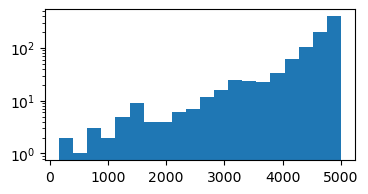

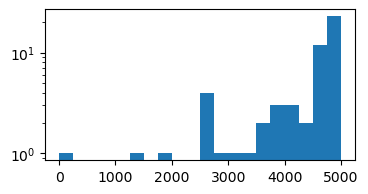

mashmap3    pi=85    ss=300   
945/1000 = 94.50% of records pass the complexity filter



In [229]:
SAMPLE_N = 1000
MIN_COMPLEXITY = 0.8
k = 19
plt.rcParams["figure.figsize"] = (4,2)
plt.rcParams["figure.dpi"] = 100
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 7}

query = "macaque"
tool = "mashmap3"
ss = 300
pi = 85

sampled_records = random.sample(params_to_results[query][(ss, pi)][tool], SAMPLE_N)
errs = []
low_complexity_errs = []
lens = []
low_complexity_lens = []
for idx, r in tqdm(enumerate(sampled_records)):
    complexity = get_min_complexity(ref, query, r) 
    min_len = min(
        r.qend - r.qstart,
        r.tend - r.tstart
    )
    if complexity >= MIN_COMPLEXITY and min_len >= k:
        errs.append((r.tags["md"].value - r.tags["gi"].value))
        lens.append(min_len)
    else:
        low_complexity_errs.append((r.tags["md"].value - r.tags["gi"].value))
        low_complexity_lens.append(min_len)
plt.hist(lens, bins=20)
plt.yscale("log")
plt.show()
plt.hist(low_complexity_lens, bins=20)
plt.yscale("log")
plt.show()
print(f"{tool:<10}  pi={pi : <4}  ss={ss : <4}  ")
print(f"{len(errs)}/{len(sampled_records)} ={100*len(errs)/len(sampled_records) : .2f}% of records pass the complexity filter")
print()


In [387]:
mm3 = list(PafFile(open("/home/Users/blk6/Contribute/wfmash/human-gorilla.L5000.ss300.oldmerge.mm3.approx.paf")))
wfmash = list(PafFile(open("/home/Users/blk6/Contribute/wfmash/human-gorilla.L5000.p90.wfmash.approx.paf")))

DescribeResult(nobs=2482, minmax=(84387, 11164591), mean=1063800.5773569702, variance=1585518751540.9077, skewness=2.6808969539082907, kurtosis=10.538338682646271)
2640353033


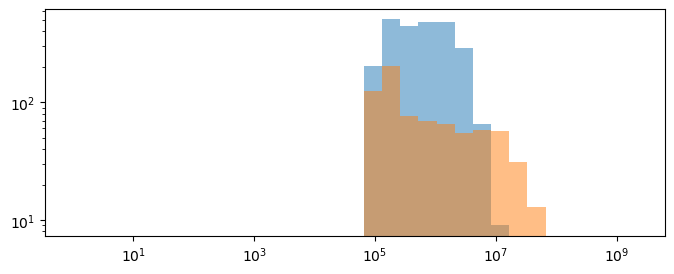

DescribeResult(nobs=755, minmax=(84905, 60486340), mean=3526659.0026490064, variance=54797001710475.26, skewness=3.4485081240020854, kurtosis=14.072493039862362)
2662627547


In [392]:
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams["figure.dpi"] = 100

mm3_filtered = [r for r in mm3 if r.query_aligned_length > 100000]
wfmash_filtered = [r for r in wfmash if   r.query_aligned_length > 100000]

plt.hist([r.tend - r.tstart for r in mm3_filtered], bins=[2**i for i in range(32)], alpha=0.5)
# plt.xscale("log")
# plt.yscale("log")
# plt.show()
print(stats.describe([r.tend - r.tstart for r in mm3_filtered]))
print(sum([r.tend - r.tstart for r in mm3_filtered]))

plt.hist([r.tend - r.tstart for r in wfmash_filtered], bins=[2**i for i in range(32)], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.show()
print(stats.describe([r.tend - r.tstart for r in wfmash_filtered]))
print(sum(([r.tend - r.tstart for r in wfmash_filtered])))

In [419]:
mm3 = list(PafFile(open("/home/Users/blk6/Contribute/wfmash/human-gorilla.L5000.ss300.oldmerge.mm3.aligned.paf")))
wfmash = list(PafFile(open("/home/Users/blk6/Contribute/wfmash/human-gorilla.L5000.p90.wfmash.aligned.paf")))

DescribeResult(nobs=18635, minmax=(138, 10680867), mean=148396.01083981755, variance=315494142459.7021, skewness=7.054413505459374, kurtosis=69.26426448839052)
2765359662


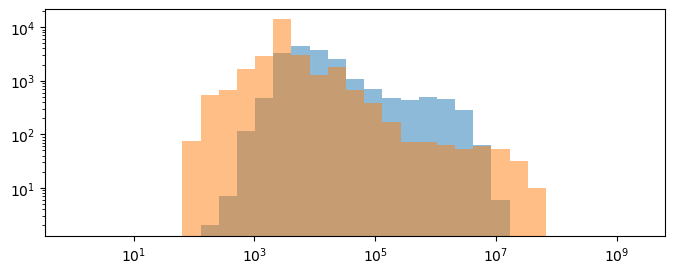

DescribeResult(nobs=27563, minmax=(101, 58444179), mean=99221.50161448319, variance=1699071163800.525, skewness=22.156987898875535, kurtosis=606.5756559534759)
2734842249


In [420]:
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams["figure.dpi"] = 100

mm3_filtered = [r for r in mm3 if r.tags["bi"].value > 1 and r.mlen > 100]
wfmash_filtered = [r for r in wfmash if r.tags["bi"].value > 1  and r.mlen > 100]

plt.hist([r.mlen for r in mm3_filtered], bins=[2**i for i in range(32)], alpha=0.5)
# plt.xscale("log")
# plt.yscale("log")
# plt.show()
print(stats.describe([r.mlen for r in mm3_filtered]))
print(sum([r.mlen for r in mm3_filtered]))

plt.hist([r.mlen for r in wfmash_filtered], bins=[2**i for i in range(32)], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.show()
print(stats.describe([r.mlen for r in wfmash_filtered]))
print(sum(([r.mlen for r in wfmash_filtered])))

In [ ]:
plt.hist([r.tags["bi"] for r in mm3_filtered], alpha=0.5)
plt.hist([r.tags["bi"] for r in wfmash_filtered], alpha=0.5)
plt.yscale("log")
plt.show()